In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from fleck import generate_spots, Stars
from scipy.stats import ks_2samp, anderson_ksamp

Load observed smoothed-amplitude distribution for comparison, plot it: 

In [29]:
#amps_slow = 2 * np.loadtxt('data/amps_slow.txt')
amps_slow = 2 * np.loadtxt('data/cluster_slow.txt')

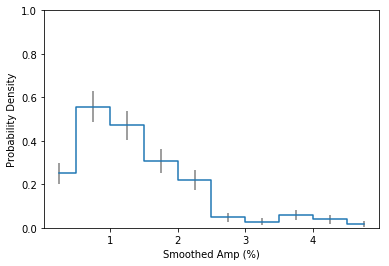

In [30]:
def norm_hist(x):
    n_bins = 10
    bin_range = [0, 5.0]
    freq, bin_edges = np.histogram(x, bins=n_bins, range=bin_range)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    dx = bin_edges[1] - bin_edges[0]
    norm = np.sum(freq * dx)
    normalized_freq = freq/norm
    normalized_freq_err = np.max([np.sqrt(freq)/norm, np.ones_like(freq)/norm], axis=0)
    return bin_centers, normalized_freq, normalized_freq_err

bin_centers, normalized_freq, normalized_freq_err = norm_hist(amps_slow)
plt.errorbar(bin_centers, normalized_freq, normalized_freq_err, 
             ls='steps-mid', ecolor='gray')
plt.ylim([0, 1])
plt.xlabel('Smoothed Amp (%)')
plt.ylabel('Probability Density')
plt.show()

Set up some intial properties of the star: 

In [31]:
ld = [0.5079, 0.2239]
stars = Stars(spot_contrast=0.7, n_phases=30, u_ld=ld)
n_inclinations = 50
spot_radius = 0.2
n_spots = 3
min_smoothed_amp = 0.01336

At each step in the chain, run function `ad`, which generates an ensemble of simulated smoothed-amplitudes for comparison with the observed distribution of smoothed amplitudes. Compute distance between the observed and simulated samples using the two-sample Anderson-Darling statistic.

In [65]:
def ad(spot_radius, min_latitude, spot_contrast):
    stars.spot_contrast = spot_contrast
    lons, lats, rads, incs = generate_spots(min_latitude=min_latitude, max_latitude=90, n_spots=n_spots,
                                            spot_radius=spot_radius, n_inclinations=n_inclinations)
    lcs = stars.light_curves(lons, lats, rads, incs)
    smoothed_amps = 100 * lcs.ptp(axis=0)
    smoothed_amps = smoothed_amps[smoothed_amps > min_smoothed_amp]
    if len(smoothed_amps) < 1: 
        anderson_stat = 100
    else: 
        anderson_stat = anderson_ksamp([smoothed_amps, amps_slow]).statistic
    return anderson_stat

n_steps = 50000
init_rad = 0.23
init_min_lat = 70
init_contrast = 0.7

Set initial conditions for the chains: 

In [66]:
p_values = [ad(init_rad, init_min_lat, init_contrast)]
spot_radii = [init_rad]
min_lats = [init_min_lat]
spot_contrasts = [init_contrast]
steps = 0
accepted_step = 0

For `n_steps`: 

1. Propose a new step by randomly perturbing the previous step's parameters
2. Compute the Anderson-Darling statistic for the new step
3. If A-D statistic < 1: accept the step
4. Append accepted step to the list of samples, return to (1)

In [67]:
while accepted_step < n_steps: 
    
    spot_radius = 0.05 * np.random.randn() + spot_radii[accepted_step-1]
    min_lat = 5*np.random.randn() + min_lats[accepted_step-1]
    spot_contrast = 0.1*np.random.randn() + spot_contrasts[accepted_step-1]
    
    # Apply prior
    if 0 < spot_radius < 1 and 0 < min_lat < 90 and 0 < spot_contrast < 1:
        adstat = ad(spot_radius, min_lat, spot_contrast)

        steps += 1
        if adstat < 1: 
            # Accept step
            spot_radii.append(spot_radius)
            min_lats.append(min_lat)
            spot_contrasts.append(spot_contrast)
            p_values.append(adstat)
            accepted_step += 1

In [68]:
print('acceptance rate:', accepted_step/steps)

acceptance rate: 0.14682174958669678


Plot each chain: 

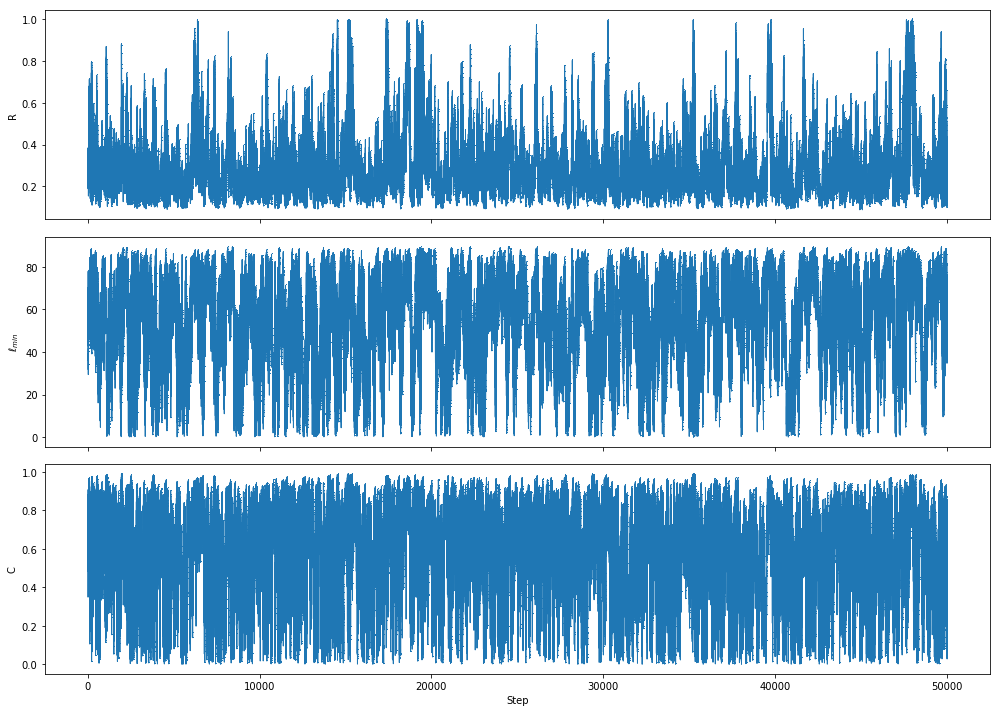

In [69]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
ax[0].plot(spot_radii, marker=',', lw=1)
ax[1].plot(min_lats, marker=',', lw=1)
ax[2].plot(spot_contrasts, marker=',', lw=1)
# ax[3].plot(p_values, marker=',', lw=0)

titles = ['R', '$\ell_{min}$', "C", '']
for axis, title in zip(ax, titles):
    axis.set_ylabel(title)
ax[-1].set_xlabel('Step')
fig.tight_layout()
# ax[2].set_ylim([-2, 3])

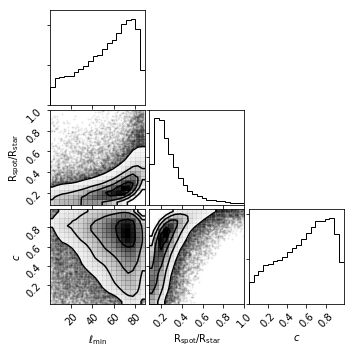

In [70]:
from corner import corner

fig, ax = plt.subplots(3, 3, figsize=(5, 5))
samples = np.array([min_lats, spot_radii, spot_contrasts]).T
corner(samples, labels='$\\rm\ell_{min}$ $\\rmR_{spot}/R_{star}$ $c$'.split(), smooth=True, fig=fig);
# fig.tight_layout()
plt.savefig('plots/corner_slow.pdf', bbox_inches='tight')

In [71]:
np.save('data/abc_samples_slow.npy', samples)